In [30]:
import os
import pandas as pd
import numpy as np

directory = '/Users/ilanastern/Desktop/aiConfidential/data'

def influence_matrix(directory):
    all_contributions = {}  # Dictionary

    for root, _, files in os.walk(directory):  # Loop through each file in the directory
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Loop only relevant files and assign either as training or validation
            if file_name.endswith(".csv") and file_name.startswith("eval_loss_meta"):
                if root.endswith("_TR.eval"):
                    split_type = "train"
                elif root.endswith("_VL.eval"):
                    split_type = "validation"
                else:
                    continue  # Skip all files that arent eval_loss_meta training

                try: #load file in 
                    data = pd.read_csv(file_path)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    continue

                avg_f1 = data['f1'].mean() #average f1 score for the file

                for _, row in data.iterrows(): # Contribution to F1 score for each data point
                    datapoint_id = row['idx']
                    f1_score = row['f1']
                    contribution = f1_score - avg_f1

                    if datapoint_id not in all_contributions:
                        all_contributions[datapoint_id] = [] #making sure each data point has a list of contributions
                    all_contributions[datapoint_id].append(contribution)

    unique_datapoints = list(all_contributions.keys()) # list of all datapoints for future plotting
    num_points = len(unique_datapoints)

    pairwise_matrix = np.zeros((num_points, num_points)) # creating pairwise matrix

    for i, dp1 in enumerate(unique_datapoints): # Calculating influnces
        for j, dp2 in enumerate(unique_datapoints):
            if i == j:
                pairwise_matrix[i, j] = 0 # A data point's influence on itself is 0
            else:
                pairwise_matrix[i, j] = np.mean(all_contributions[dp1]) - np.mean(all_contributions[dp2]) # Influence of dp1 on dp2

    pairwise_df = pd.DataFrame(pairwise_matrix,index=unique_datapoints,columns=unique_datapoints) #making matrix into a dataframe

    return pairwise_df

pairwise_influence_df = calculate_pairwise_influence_matrix(directory)
pairwise_influence_df.to_csv("pairwise_influence_matrix.csv", index=True)


Matching Indices: Index(['27111', '37068', '25332', '28408', '24457', '32639', '27164', '26223',
       '33998', '31648',
       ...
       '34612', '33326', '31718', '34888', '25574', '27127', '36542', '39264',
       '27076', '34284'],
      dtype='object', length=2843)
Matching Columns: Index(['27111', '37068', '25332', '28408', '24457', '32639', '27164', '26223',
       '33998', '31648',
       ...
       '34612', '33326', '31718', '34888', '25574', '27127', '36542', '39264',
       '27076', '34284'],
      dtype='object', length=2843)
Filtered similarity_df shape: (2843, 2843)
Filtered pairwise_influence_df shape: (2843, 2843)
Collected Similarity Scores: [1.0, 0.3014354066985646, 0.2369146005509642, 0.17793594306049823, 0.32722832722832723, 0.1615798922800718, 0.508695652173913, 0.36184857423795475, 0.1615798922800718, 0.1595744680851064]
Collected Influence Scores: [0.0, -0.00650101949535957, 0.12524094988588383, -0.24732187295722308, -0.008354157821814395, -0.2533932019290856, 

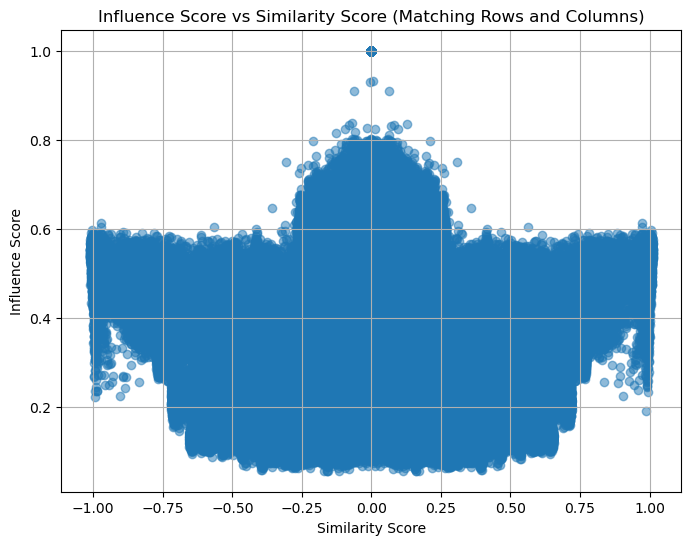

In [32]:
import matplotlib.pyplot as plt

def plot_influence_vs_similarity(pairwise_influence_df):
    similarity_df = pickle # Load similarity matrix from pickle file, stored in FunctionsAndData.py

    # Convert indices and column names to strings, then extract the portion before the underscore
    pairwise_influence_df.index = pairwise_influence_df.index.astype(str).str.split('_').str[0]
    pairwise_influence_df.columns = pairwise_influence_df.columns.astype(str).str.split('_').str[0]
    similarity_df.index = similarity_df.index.astype(str).str.split('_').str[0]
    similarity_df.columns = similarity_df.columns.astype(str).str.split('_').str[0]

    # Ensure indices and columns match in both dataframes
    matching_indices = pairwise_influence_df.index.intersection(similarity_df.index)
    matching_columns = pairwise_influence_df.columns.intersection(similarity_df.columns)

    print(f"Matching Indices: {matching_indices}") #print matching indicies as a check
    print(f"Matching Columns: {matching_columns}")

    similarity_df = similarity_df.loc[matching_indices, matching_columns] # Filter both matrices to only include matching rows and columns
    pairwise_influence_df = pairwise_influence_df.loc[matching_indices, matching_columns]

    print(f"Filtered similarity_df shape: {similarity_df.shape}") #shape should be same. Debugging check
    print(f"Filtered pairwise_influence_df shape: {pairwise_influence_df.shape}")

    influence_scores = []
    similarity_scores = []

    for idx in matching_indices:
        for col in matching_columns:
            if idx in similarity_df.index and col in similarity_df.columns:
                similarity_score = similarity_df.loc[idx, col]
                influence_score = pairwise_influence_df.loc[idx, col]

                similarity_score = pd.to_numeric(similarity_score, errors='coerce') #errors set to NaN. making sure it's a number
                influence_score = pd.to_numeric(influence_score, errors='coerce')

                if pd.notna(similarity_score) and pd.notna(influence_score): #append if exists
                    similarity_scores.append(similarity_score)
                    influence_scores.append(influence_score)

    print(f"Collected Similarity Scores: {similarity_scores[:10]}")  # Show first 10 values for debugging
    print(f"Collected Influence Scores: {influence_scores[:10]}")    # Show first 10 values for debugging

    # Ensure valid data for plotting
    if len(influence_scores) == 0 or len(similarity_scores) == 0:
        print("No valid data for plotting. Check your DataFrames or filters.")
        return
    
    print(len(influence_scores)) #debugging check
    print(len(similarity_scores))
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(influence_scores, similarity_scores, alpha=0.5)
    plt.title("Influence Score vs Similarity Score (Matching Rows and Columns)")
    plt.xlabel("Similarity Score")
    plt.ylabel("Influence Score")
    plt.grid(True)
    plt.show()


# Plot the graph of influence vs similarity
plot_influence_vs_similarity(pairwise_influence_df)
